### Train a first baseline using Oracle AutoML

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import tempfile

import ads
from ads import set_auth

# AutoML
from ads.automl.driver import AutoML
from ads.automl.provider import OracleAutoMLProvider
from ads.evaluations.evaluator import ADSEvaluator


from sklearn.metrics import classification_report
from sklearn.metrics import get_scorer, make_scorer, f1_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from ads.dataset.factory import DatasetFactory

import logging
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

%matplotlib inline

In [2]:
# set RP
set_auth(auth='resource_principal')

In [3]:
# load the dataset
TARGET = 'Attrition'
TEST_FRAC = 0.2

attrition_path = "/opt/notebooks/ads-examples/oracle_data/orcl_attrition.csv"

ds1 = DatasetFactory.open(attrition_path, target=TARGET).set_positive_class('Yes')

ds_train1, ds_test1 = ds1.train_test_split(test_size=TEST_FRAC, random_state = 42)

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

### A First AutoML session

In [4]:
ml_engine = OracleAutoMLProvider(n_jobs=-1, loglevel=logging.ERROR)
oracle_automl = AutoML(ds_train1, provider=ml_engine)

model1, baseline = oracle_automl.train(
                      model_list=['LGBMClassifier', 'XGBClassifier', 'RandomForestClassifier'],
                      random_state = 42, time_budget = 600, score_metric='accuracy')

[15:14:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
INFO:xengine:All work stopped
INFO:xengine:All work stopped


Training Dataset size,"(1176, 35)"
Validation Dataset size,None
CV,5
Target variable,Attrition
Optimization Metric,accuracy
Initial number of Features,35
Selected number of Features,23
Selected Features,"Index(['Age', 'TravelForWork_2', 'TravelForWork_3', 'JobFunction_2', 'JobFunction_3', 'CommuteLength', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus_1', 'MaritalStatus_2', 'MaritalStatus_3', 'MonthlyIncome', 'OverTime_1', 'OverTime_2', 'StockOptionLevel', 'YearsinIndustry', 'TrainingTimesLastYear', 'YearsOnJob', 'YearsAtCurrentLevel', 'YearsWithCurrManager'], dtype='object')"
Selected Algorithm,XGBClassifier
End-to-end Elapsed Time (seconds),76.4721
Selected Hyperparameters,"{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'dart', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}"


Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time,Memory Usage
2,XGBClassifier_HT,1176,23,0.8784,"{'booster': 'dart', 'learning_rate': 0.100009999, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",9.7263,0.0000e+00
3,XGBClassifier_ANOVAF_FS,1176,23,0.8784,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",2.2065,0.0000e+00
4,XGBClassifier_HT,1176,23,0.8784,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 4e-05, 'reg_lambda': 1}",2.7393,0.0000e+00
5,XGBClassifier_HT,1176,23,0.8784,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 4.000000000000001e-05, 'reg_lambda': 1}",2.7240,0.0000e+00
6,XGBClassifier_HT,1176,23,0.8784,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 8.000000000000002e-05, 'reg_lambda': 1}",2.6921,0.0000e+00
...,...,...,...,...,...,...,...
161,XGBClassifier_AdaBoostClassifier_FS,1176,6,0.8197,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",2.0675,0.0000e+00
162,XGBClassifier_AdaBoostClassifier_FS,1176,4,0.8197,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",1.7844,1.1444e-05
163,XGBClassifier_RandomForestClassifier_FS,1176,1,0.8163,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",1.8222,7.6294e-06
164,XGBClassifier_RandomForestClassifier_FS,1176,2,0.8146,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",1.6275,0.0000e+00


In [5]:
model1.show_in_notebook()

Model Name,AutoML Classifier
Target Variable,Attrition
Selected Algorithm,XGBClassifier
Task,classification
Training Dataset Size,"(1176, 35)"
CV,5
Optimization Metric,accuracy
Selected Hyperparameters,"{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'dart', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}"
Initial Number of Features,35
Initial Features,"Index(['Age', 'TravelForWork_1', 'TravelForWork_2', 'TravelForWork_3', 'SalaryLevel', 'JobFunction_1', 'JobFunction_2', 'JobFunction_3', 'CommuteLength', 'EducationalLevel', 'EducationField', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender_1', 'Gender_2', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus_1', 'MaritalStatus_2', 'MaritalStatus_3', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime_1', 'OverTime_2', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'YearsinIndustry', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsOnJob', 'YearsAtCurrentLevel', 'YearsSinceLastPromotion', 'YearsWithCurrManager'], dtype='object')"
Selected Number of Features,23


[['Model Name', 'AutoML Classifier'],
 ['Target Variable', 'Attrition'],
 ['Selected Algorithm', 'XGBClassifier'],
 ['Task', 'classification'],
 ['Training Dataset Size', (1176, 35)],
 ['CV', 5],
 ['Optimization Metric', 'accuracy'],
 ['Selected Hyperparameters',
  {'objective': 'binary:logistic',
   'use_label_encoder': True,
   'base_score': 0.5,
   'booster': 'dart',
   'colsample_bylevel': 1,
   'colsample_bynode': 1,
   'colsample_bytree': 1,
   'enable_categorical': False,
   'gamma': 0,
   'gpu_id': -1,
   'importance_type': None,
   'interaction_constraints': '',
   'learning_rate': 0.1,
   'max_delta_step': 0,
   'max_depth': 3,
   'min_child_weight': 1,
   'missing': nan,
   'monotone_constraints': '()',
   'n_estimators': 100,
   'n_jobs': 1,
   'num_parallel_tree': 1,
   'predictor': 'auto',
   'random_state': 42,
   'reg_alpha': 0,
   'reg_lambda': 1,
   'scale_pos_weight': 1,
   'subsample': 1,
   'tree_method': 'exact',
   'validate_parameters': 1,
   'verbosity': None}]

### Do the up-sampling and repeat the AutoML

In [6]:
# load the dataset
TARGET = 'Attrition'

attrition_path = "/opt/notebooks/ads-examples/oracle_data/orcl_attrition.csv"

ds2 = DatasetFactory.open(attrition_path, target=TARGET).set_positive_class('Yes')

# usa imbalanced_learn
ds2 = ds2.up_sample()

ds_train2, ds_test2 = ds2.train_test_split(test_size=TEST_FRAC, random_state = 42)

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
ml_engine = OracleAutoMLProvider(n_jobs=-1, loglevel=logging.ERROR)
oracle_automl = AutoML(ds_train2, provider=ml_engine)

model2, baseline2 = oracle_automl.train(
                      model_list=['LGBMClassifier', 'XGBClassifier', 'RandomForestClassifier'],
                      random_state = 42, time_budget = 600, score_metric='accuracy')

INFO:xengine:All work stopped
INFO:xengine:All work stopped
INFO:xengine:All work stopped
INFO:xengine:All work stopped


Training Dataset size,"(1972, 35)"
Validation Dataset size,None
CV,5
Target variable,Attrition
Optimization Metric,accuracy
Initial number of Features,35
Selected number of Features,28
Selected Features,"Index(['Age', 'TravelForWork_1', 'TravelForWork_2', 'TravelForWork_3', 'JobFunction_1', 'JobFunction_2', 'JobFunction_3', 'CommuteLength', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus_1', 'MaritalStatus_2', 'MaritalStatus_3', 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime_1', 'OverTime_2', 'StockOptionLevel', 'YearsinIndustry', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsOnJob', 'YearsAtCurrentLevel', 'YearsSinceLastPromotion', 'YearsWithCurrManager'], dtype='object')"
Selected Algorithm,RandomForestClassifier
End-to-end Elapsed Time (seconds),42.0062
Selected Hyperparameters,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 0.03571428571428571, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.0005070993914807302, 'min_samples_split': 0.0010141987829614604, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}"


Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time,Memory Usage
2,RandomForestClassifier_HT,1972,28,0.9711,"{'class_weight': 'balanced_subsample', 'max_features': 0.03571428571428571, 'min_samples_leaf': 0.0005070993914807302, 'min_samples_split': 0.0010141987829614604, 'n_estimators': 100}",3.7964,0.0000
3,RandomForestClassifier_HT,1972,28,0.9701,"{'class_weight': None, 'max_features': 0.03571428571428571, 'min_samples_leaf': 0.0005070993914807302, 'min_samples_split': 0.0010141987829614604, 'n_estimators': 100}",2.5367,0.0000
4,RandomForestClassifier_HT,1972,28,0.9701,"{'class_weight': 'balanced_subsample', 'max_features': 0.03571428571428571, 'min_samples_leaf': 0.0005070993914807302, 'min_samples_split': 0.0010141987829614604, 'n_estimators': 252}",7.7570,0.0054
5,RandomForestClassifier_HT,1972,28,0.9696,"{'class_weight': 'balanced_subsample', 'max_features': 0.03571428571428571, 'min_samples_leaf': 0.0005070993914807302, 'min_samples_split': 0.0010141987829614604, 'n_estimators': 253}",7.9838,0.0040
6,RandomForestClassifier_HT,1972,28,0.9686,"{'class_weight': 'balanced', 'max_features': 0.03571428571428571, 'min_samples_leaf': 0.0005070993914807302, 'min_samples_split': 0.0010141987829614604, 'n_estimators': 252}",4.3767,0.0000
...,...,...,...,...,...,...,...
136,RandomForestClassifier_HT,1972,28,0.7221,"{'class_weight': 'balanced_subsample', 'max_features': 0.03571428571428571, 'min_samples_leaf': 0.0005070993914807302, 'min_samples_split': 0.17889367618638138, 'n_estimators': 5}",0.2382,0.0000
137,RandomForestClassifier_HT,1972,28,0.7221,"{'class_weight': 'balanced_subsample', 'max_features': 0.03571428571428571, 'min_samples_leaf': 0.0005070993914807302, 'min_samples_split': 0.17890366604439356, 'n_estimators': 5}",0.2209,0.0000
138,RandomForestClassifier_ANOVAF_FS,1972,1,0.6582,"{'n_estimators': 100, 'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",2.2707,0.0000
139,RandomForestClassifier_ANOVAF_FS,1972,2,0.6582,"{'n_estimators': 100, 'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",2.3181,0.0000


### confrontiamo i due modelli (model1 e model2) su ds_test1

In [8]:
model1.rename("GBM-not-upsampled")
model2.rename("GBM-upsampled")

# uso ADSEvaluator
evaluator = ADSEvaluator(ds_test1, models=[model1, model2])

In [9]:
evaluator.metrics

,GBM-not-upsampled,GBM-upsampled
Accuracy,0.8741,0.9898
Hamming distance,0.1259,0.0102
Precision,0.5556,0.9737
Recall,0.2564,0.9487
F1,0.3509,0.9610
ROC AUC,0.6125,0.9724


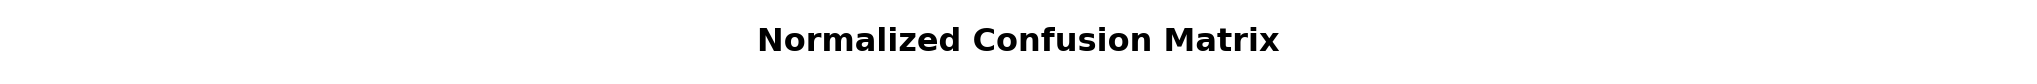

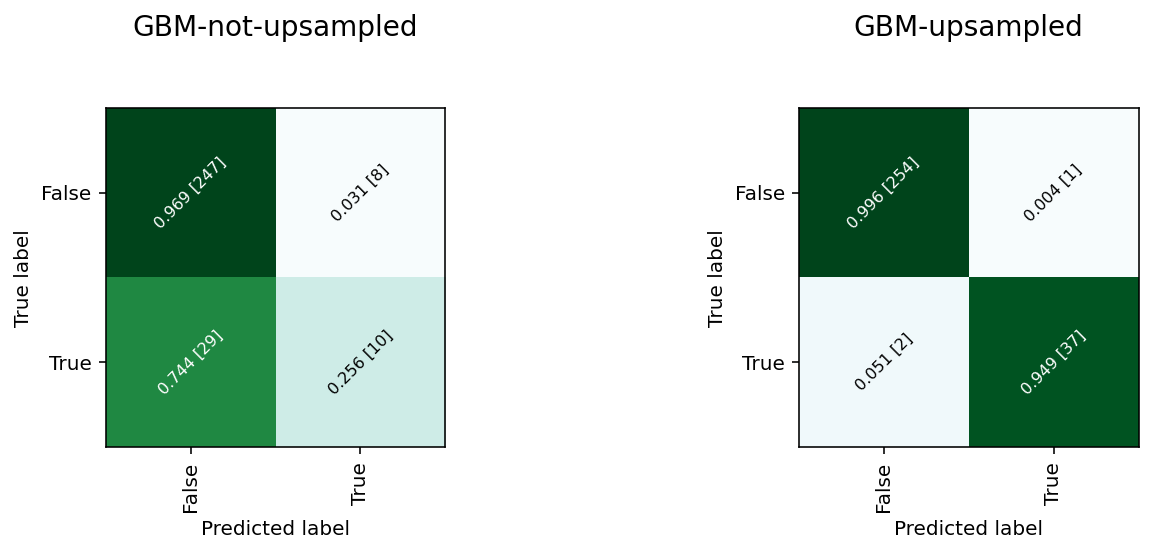

In [10]:
evaluator.show_in_notebook(perfect=True, plots=['normalized_confusion_matrix'])